In [1]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_excel("/Users/alexandrebredillot/Documents/GitHub/EXP_GO/EDH - /Machine Learning/assignement/training_dataset.xlsx")

In [6]:
print(df.head())

   URBRRL  RATCAT_A  INCGRP_A  INCTCFLG_A  FAMINCTC_A  IMPINCFLG_A  \
0       2        11         3           0       70000            0   
1       4         6         1           0       30000            0   
2       3        11         3           0       63464            0   
3       3         5         1           0       25000            2   
4       4        13         4           0       75000            0   

   RJWKCLSOFT_A  RJWCLSNOSD_A  RJWRKCLSSD_A  RECJOBSD_A  ...  PHSTAT_A  \
0           NaN           NaN           NaN         NaN  ...         3   
1           NaN           NaN           NaN         NaN  ...         1   
2           NaN           NaN           NaN         NaN  ...         1   
3           NaN           NaN           NaN         NaN  ...         3   
4           NaN           NaN           NaN         NaN  ...         4   

   PROXYREL_A  PROXY_A  AVAIL_A  HHSTAT_A  INTV_MON  RECTYPE     WTFA_A  \
0         NaN      NaN        1         1         3       1

In [ ]:
# Feature selection (early): use provided variable names/descriptions
import re
import pandas as pd

# Load code -> description mapping from the same Excel file (sheet: 'variable names')
_meta_path = "/Users/alexandrebredillot/Documents/GitHub/EXP_GO/EDH - /Machine Learning/assignement/training_dataset.xlsx"
var_info = pd.read_excel(_meta_path, sheet_name="variable names")
var_info["Variable code"] = var_info["Variable code"].astype(str).str.strip()
var_info["Variable name"] = var_info["Variable name"].astype(str).str.strip()

desc_map = dict(zip(var_info["Variable code"], var_info["Variable name"]))
print("Loaded variable metadata:", var_info.shape, "| mapped codes:", len(desc_map))

def select_features_by_description(df_features: pd.DataFrame, desc_map: dict[str, str]):
    """Drop clearly administrative / survey-design / ID-like fields using provided descriptions.

    Keeps the logic conservative: we only drop when the description strongly suggests
    the field is metadata rather than a meaningful predictor.
    """
    cols = list(df_features.columns)
    keep = set(cols)

    def _desc(c: str) -> str:
        return str(desc_map.get(c, "")).strip()

    # 1) Hard drops by variable code (known administrative fields)
    hard_drop_codes = {
        "HHX",      # household identifier
        "WTFA_A",   # survey weight
        "RECTYPE",  # record type
    }
    for c in list(keep):
        if c in hard_drop_codes:
            keep.remove(c)

    # 2) Drops by description keywords (conservative)
    keyword_patterns = [
        r"\bweight\b",
        r"\brecord type\b",
        r"\bhousehold\b",
        r"\bidentifier\b",
        r"\binterview\b",
        r"\bsample design\b",
        r"\bproxy\b",
        r"\bavailability\b",
    ]
    keyword_re = re.compile("|".join(keyword_patterns), flags=re.IGNORECASE)

    for c in list(keep):
        d = _desc(c)
        if d and keyword_re.search(d):
            keep.remove(c)

    # 3) Remove redundant variants when a 'Standard Data' version exists
    # We group by a base description where we remove the variant qualifier.
    def _base_desc(d: str) -> str:
        d = re.sub(r"\s+Standard Data\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+No Standard Data\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+Soft\s*$", "", d, flags=re.IGNORECASE)
        d = re.sub(r"\s+[A-Z]$", "", d)  # trailing 'A' (common in this dataset)
        return d.strip().lower()

    # Build groups by base description
    groups: dict[str, list[str]] = {}
    for c in cols:
        d = _desc(c)
        if not d:
            continue
        base = _base_desc(d)
        if base:
            groups.setdefault(base, []).append(c)

    for base, cs in groups.items():
        if len(cs) < 2:
            continue
        # if there is a standard-data column in the group, drop the soft/no-std ones
        standard = [c for c in cs if re.search(r"Standard Data\s*[A-Z]?$", _desc(c), flags=re.IGNORECASE)]
        if not standard:
            continue
        for c in cs:
            d = _desc(c)
            if re.search(r"(Soft|No Standard Data)\s*[A-Z]?$", d, flags=re.IGNORECASE):
                if c in keep:
                    keep.remove(c)

    dropped = [c for c in cols if c not in keep]
    return sorted(keep), dropped

selected_cols, dropped_cols = select_features_by_description(df, desc_map)
print("Early feature selection:")
print("  original columns:", df.shape[1])
print("  kept columns:", len(selected_cols))
print("  dropped columns:", len(dropped_cols))
if dropped_cols:
    preview = [(c, desc_map.get(c, "")) for c in dropped_cols[:25]]
    print("\nDropped (first 25):")
    for c, d in preview:
        print(f"  {c}: {d}")

In [ ]:
# Lasso + ElasticNet (with preprocessing + CV)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import difflib

# --- Choose target column ---
requested_target = "weightlbtc_A"
target_column = None

# 1) exact match
if requested_target in df.columns:
    target_column = requested_target
else:
    # 2) case-insensitive match
    lowered = {c.lower(): c for c in df.columns}
    if requested_target.lower() in lowered:
        target_column = lowered[requested_target.lower()]

if target_column is None:
    # 3) show helpful suggestions and stop
    close = difflib.get_close_matches(requested_target, df.columns, n=10, cutoff=0.6)
    contains = [c for c in df.columns if any(k in c.lower() for k in ["weight", "wgt", "lb"])][:30]
    raise ValueError(
        "Target column not found. "
        f"Requested: {requested_target!r}. "
        f"Close matches: {close}. "
        f"Columns containing 'weight'/'wgt'/'lb' (first 30): {contains}"
    )

print("Target:", target_column)
print("df shape:", df.shape)
print("Target dtype:", df[target_column].dtype, "| missing:", df[target_column].isna().mean().round(4))

# --- Build X/y ---
X = df.drop(columns=[target_column])
y = df[target_column]

# Apply early feature selection (description-based) if available
try:
    if "selected_cols" in globals():
        # selected_cols was computed on df (including target); keep only those present in X
        _keep = [c for c in selected_cols if c in X.columns]
        dropped_early = [c for c in X.columns if c not in set(_keep)]
        X = X[_keep]
        print(f"Applied early feature selection -> kept {X.shape[1]} predictors; dropped {len(dropped_early)}")
except Exception as e:
    print("Early feature selection skipped due to:", repr(e))

# Drop obvious ID-like columns (very high cardinality strings)
object_cols = X.select_dtypes(include=["object"]).columns.tolist()
id_like = [c for c in object_cols if X[c].nunique(dropna=True) > 0.9 * len(X)]
if id_like:
    print("Dropping ID-like columns:", id_like)
    X = X.drop(columns=id_like)

# Basic split (reproducible)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
 )

# Drop features that are entirely missing in the TRAIN split (avoids imputer warnings)
all_missing = [c for c in X_train.columns if X_train[c].isna().all()]
if all_missing:
    print("Dropping all-missing columns (train):", all_missing)
    X_train = X_train.drop(columns=all_missing)
    X_test = X_test.drop(columns=all_missing, errors="ignore")

numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# IMPORTANT for MSE-based evaluation: scale numeric features (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
 ])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
 ])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
 )

# --- Lasso (CV) ---
# Use alphas=100 to match sklearn's upcoming default and silence the deprecation warning
lasso = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LassoCV(alphas=100, cv=5, random_state=42, n_jobs=-1, max_iter=20000)),
 ])

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

rmse_lasso = float(np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

print("\nLassoCV")
print("  alpha:", float(lasso.named_steps["model"].alpha_))
print("  R2:", round(r2_score(y_test, y_pred_lasso), 4))
print("  MAE:", round(mean_absolute_error(y_test, y_pred_lasso), 4))
print("  RMSE:", round(rmse_lasso, 4))

# --- ElasticNet (CV) ---
# ElasticNetCV cross-validates both alpha and l1_ratio
enet = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        alphas=100,
        cv=5,
        random_state=42,
        n_jobs=-1,
        max_iter=20000,
    )),
 ])

enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)

rmse_enet = float(np.sqrt(mean_squared_error(y_test, y_pred_enet)))

print("\nElasticNetCV")
print("  alpha:", float(enet.named_steps["model"].alpha_))
print("  l1_ratio:", float(enet.named_steps["model"].l1_ratio_))
print("  R2:", round(r2_score(y_test, y_pred_enet), 4))
print("  MAE:", round(mean_absolute_error(y_test, y_pred_enet), 4))
print("  RMSE:", round(rmse_enet, 4))

# --- Top coefficients (interpretability) ---
def top_coefficients(pipeline, top_k=20):
    pre = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        feature_names = None
    coef = model.coef_
    if feature_names is None:
        print("(Could not fetch feature names; showing coefficient indices)")
        idx = np.argsort(np.abs(coef))[::-1][:top_k]
        for i in idx:
            print(f"  idx={i:>5} coef={coef[i]: .6f}")
        return
    idx = np.argsort(np.abs(coef))[::-1][:top_k]
    for i in idx:
        print(f"  {feature_names[i]:<40} coef={coef[i]: .6f}")

print("\nTop Lasso coefficients:")
top_coefficients(lasso, top_k=20)

print("\nTop ElasticNet coefficients:")
top_coefficients(enet, top_k=20)

Target: WEIGHTLBTC_A
df shape: (20340, 617)
Target dtype: int64 | missing: 0.0
Dropping ID-like columns: ['HHX']
Dropping all-missing columns (train): ['OGFLG_A', 'CHFLG_A', 'PRPLCOV2_C_A']

LassoCV
  alpha: 0.21886402297465457
  R2: 0.7036
  MAE: 13.3574
  RMSE: 21.4518

ElasticNetCV
  alpha: 0.21150751743457932
  l1_ratio: 0.9
  R2: 0.7052
  MAE: 13.4097
  RMSE: 21.3921

Top Lasso coefficients:
  BMICAT_A                                 coef= 25.980913
  HEIGHTTC_A                               coef= 9.334418
  SEX_A                                    coef=-7.850243
  ADVEAT_A                                 coef=-3.308423
  AGEP_A                                   coef=-2.081097
  SCHCURENR_A                              coef= 1.583823
  PHSTAT_A                                 coef= 1.285172
  DIFF_A                                   coef= 1.067282
  NATUSBORN_A                              coef=-1.064115
  HYPEV_A                                  coef=-0.920816
  RACEALLP_A       

Explained variance ratio (PC1, PC2): [0.0813 0.0402]


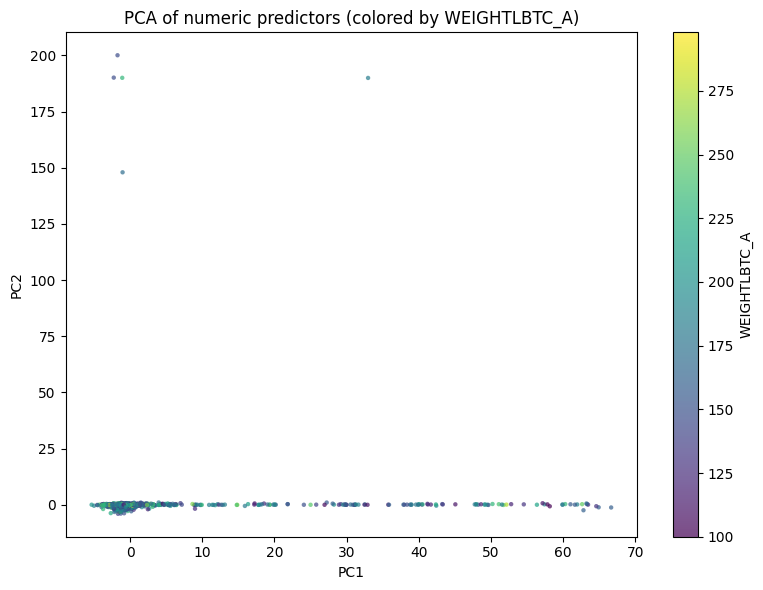

In [13]:
# PCA plot (numeric features only)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# We'll do PCA on numeric predictors only (after the same X_train/X_test cleanup already done above).
X_num_train = X_train.select_dtypes(include=[np.number])
X_num_test = X_test.select_dtypes(include=[np.number])

# Impute + scale numeric features
num_pca_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

X_num_train_scaled = num_pca_prep.fit_transform(X_num_train)
X_num_test_scaled = num_pca_prep.transform(X_num_test)

pca = PCA(n_components=2, random_state=42)
Z_train = pca.fit_transform(X_num_train_scaled)
Z_test = pca.transform(X_num_test_scaled)

print("Explained variance ratio (PC1, PC2):", np.round(pca.explained_variance_ratio_, 4))

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    Z_test[:, 0],
    Z_test[:, 1],
    c=y_test,
    s=10,
    alpha=0.7,
    cmap="viridis",
    edgecolors="none",
 )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of numeric predictors (colored by {target_column})")
cb = plt.colorbar(sc)
cb.set_label(target_column)
plt.tight_layout()
plt.show()

In [16]:
# Rank original numeric features by contribution to variance captured by PC1/PC2
import pandas as pd
import numpy as np

feature_names = X_num_train.columns.to_numpy()
loadings = pca.components_.T  # (n_features, 2) because n_components=2
evr = pca.explained_variance_ratio_[: loadings.shape[1]]

# Contribution score in *explained-variance-ratio* units: sum_k (EVR_k * loading_{feature,k}^2)
contrib = (loadings**2) @ evr
contrib_pc1 = loadings[:, 0] ** 2
contrib_pc2 = loadings[:, 1] ** 2

rank_df = pd.DataFrame({
    "feature": feature_names,
    "pc1_loading": loadings[:, 0],
    "pc2_loading": loadings[:, 1],
    "pc1_contrib(loading^2)": contrib_pc1,
    "pc2_contrib(loading^2)": contrib_pc2,
    "combined_contrib(EVR-weighted)": contrib,
}).sort_values("combined_contrib(EVR-weighted)", ascending=False)

# Cumulative share within the variance captured by PC1+PC2
total_captured = float(evr.sum())
rank_df["cum_contrib(EVR-weighted)"] = rank_df["combined_contrib(EVR-weighted)"].cumsum()
rank_df["cum_%_of_PC1+PC2"] = 100.0 * rank_df["cum_contrib(EVR-weighted)"] / total_captured

top_n = 30
topn_captured = float(rank_df.head(top_n)["combined_contrib(EVR-weighted)"].sum())
topn_pct_of_captured = 100.0 * topn_captured / total_captured
topn_pct_of_total_variance = 100.0 * topn_captured  # since EVR is already a ratio of total variance

print("Explained variance ratio:", np.round(evr, 6), "| total PC1+PC2:", round(total_captured, 6))
print(
    f"Top {top_n} features contribute {topn_captured:.6f} EVR units -> "
    f"{topn_pct_of_captured:.2f}% of the variance captured by PC1+PC2 "
    f"(= {topn_pct_of_total_variance:.2f}% of total variance)."
)
print("\nTop 30 features (descending):")
display(rank_df.head(top_n))

Explained variance ratio: [0.081275 0.040182] | total PC1+PC2: 0.121456
Top 30 features contribute 0.043870 EVR units -> 36.12% of the variance captured by PC1+PC2 (= 4.39% of total variance).

Top 30 features (descending):


,feature,pc1_loading,pc2_loading,pc1_contrib(loading^2),pc2_contrib(loading^2),combined_contrib(EVR-weighted),cum_contrib(EVR-weighted),cum_%_of_PC1+PC2
217,LARYNCAN_A,-0.000820,0.201764,6.720685e-07,4.070858e-02,0.001636,0.001636,1.346813
218,GALLBCAN_A,-0.000829,0.201721,6.872045e-07,4.069143e-02,0.001635,0.003271,2.693059
219,ESOPHCAN_A,-0.000810,0.201204,6.553330e-07,4.048296e-02,0.001627,0.004898,4.032406
211,MOUTHCAN_A,-0.001236,0.200978,1.528771e-06,4.039226e-02,0.001623,0.006521,5.368811
209,PANCRCAN_A,-0.000941,0.200689,8.856951e-07,4.027623e-02,0.001618,0.008139,6.701335
203,STOMACAN_A,-0.000798,0.200665,6.369691e-07,4.026651e-02,0.001618,0.009757,8.033520
225,BLOODCAN_A,-0.000775,0.200609,6.001935e-07,4.024391e-02,0.001617,0.011374,9.364955
224,BONECAN_A,-0.000770,0.200358,5.927747e-07,4.014316e-02,0.001613,0.012987,10.693056
207,RECTUCAN_A,-0.000680,0.199503,4.626618e-07,3.980133e-02,0.001599,0.014587,12.009840
215,LIVERCAN_A,-0.000672,0.198919,4.517734e-07,3.956877e-02,0.001590,0.016177,13.318930


In [19]:
# Ranking of PCA components by explained variance (scree table)
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Fit PCA with the maximum possible number of components
# (limited by min(n_samples, n_features))
max_components = int(min(X_num_train_scaled.shape[0], X_num_train_scaled.shape[1]))
pca_full = PCA(n_components=max_components, random_state=42)
pca_full.fit(X_num_train_scaled)

evr_full = pca_full.explained_variance_ratio_
cum_full = np.cumsum(evr_full)

pc_rank = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(evr_full))],
    "explained_variance_ratio": evr_full,
    "cumulative_explained_variance": cum_full,
})

print("Top 20 PCs by explained variance:")
display(pc_rank.head(20))

# How many PCs needed for common thresholds (including 98%)
for thr in [0.5, 0.8, 0.9, 0.95, 0.98]:
    k = int(np.searchsorted(cum_full, thr) + 1)
    print(f"PCs needed for {int(thr*100)}% variance: {k}")

Top 20 PCs by explained variance:


,PC,explained_variance_ratio,cumulative_explained_variance
0,PC1,0.081275,0.081275
1,PC2,0.040182,0.121456
2,PC3,0.024523,0.145979
3,PC4,0.020096,0.166075
4,PC5,0.015899,0.181974
5,PC6,0.015080,0.197054
6,PC7,0.014321,0.211375
7,PC8,0.013512,0.224887
8,PC9,0.010397,0.235283
9,PC10,0.009506,0.244789


PCs needed for 50% variance: 79
PCs needed for 80% variance: 250
PCs needed for 90% variance: 339
PCs needed for 95% variance: 402
PCs needed for 98% variance: 462


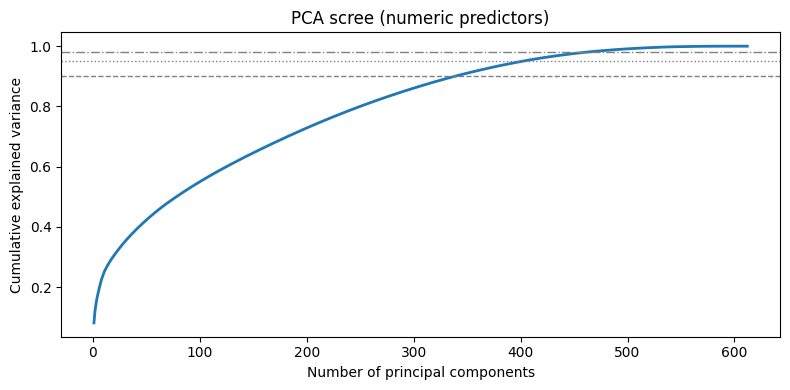

|PC2| quantiles: {'50%': np.float64(0.0995), '90%': np.float64(0.5872), '95%': np.float64(0.9607), '99%': np.float64(1.9168), '99.9%': np.float64(138.3121)}

Top 10 |PC2| points (test set):


,PC1,PC2,WEIGHTLBTC_A
13405,-1.758482,200.048597,146
10317,-2.280210,190.092904,146
17980,-1.105103,190.007863,230
3511,32.973039,189.956628,183
3522,-1.058092,147.956262,170
19593,-1.690712,-4.013660,140
9119,-1.314395,-3.924063,150
15413,-0.844754,-3.773115,151
17261,-2.694733,-3.713309,220
10422,-2.188373,-3.212601,165



PC1+PC2 explained variance: 0.1215


In [20]:
# PCA sanity checks (is PCA "good"?)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Scree curve: cumulative explained variance vs #PCs
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(evr_full) + 1), np.cumsum(evr_full), linewidth=2)
plt.axhline(0.90, color="gray", linestyle="--", linewidth=1)
plt.axhline(0.95, color="gray", linestyle=":", linewidth=1)
plt.axhline(0.98, color="gray", linestyle="-.", linewidth=1)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA scree (numeric predictors)")
plt.tight_layout()
plt.show()

# 2) Outlier check in PC space (helps explain a "squashed" plot)
pc2_abs = np.abs(Z_test[:, 1])
q = np.quantile(pc2_abs, [0.5, 0.9, 0.95, 0.99, 0.999])
print("|PC2| quantiles:", dict(zip(["50%","90%","95%","99%","99.9%"], np.round(q, 4))))

top_k = 10
idx = np.argsort(pc2_abs)[-top_k:][::-1]
outlier_view = pd.DataFrame({
    "PC1": Z_test[idx, 0],
    "PC2": Z_test[idx, 1],
    target_column: y_test.iloc[idx].values,
}, index=y_test.iloc[idx].index)
print(f"\nTop {top_k} |PC2| points (test set):")
display(outlier_view)

# 3) Quick check: how much variance is in PC1+PC2 (you already printed this, but keeping here)
print("\nPC1+PC2 explained variance:", round(float(pca.explained_variance_ratio_.sum()), 4))

In [21]:
# Correlation analysis + RandomForest feature importance + best prediction score
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ----------------------------
# 1) Correlation analysis (numeric only)
# ----------------------------
X_num = X_train.select_dtypes(include=[np.number]).copy()
corr = X_num.corrwith(y_train).dropna().sort_values(key=lambda s: s.abs(), ascending=False)

corr_df = pd.DataFrame({"corr_with_target": corr, "abs_corr": corr.abs()}).sort_values("abs_corr", ascending=False)
print("Top 20 numeric features by |correlation| with target:")
display(corr_df.head(20))

# ----------------------------
# 2) RandomForest model + feature importances
# ----------------------------
numeric_features_rf = X_train.select_dtypes(include=[np.number]).columns
categorical_features_rf = X_train.select_dtypes(exclude=[np.number]).columns

rf_preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features_rf),
        (
            "cat",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
            ]),
            categorical_features_rf,
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0.3,
 )

rf_model = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2,
 )

rf = Pipeline(steps=[("preprocess", rf_preprocess), ("model", rf_model)])
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = float(np.sqrt(mean_squared_error(y_test, y_pred_rf)))
r2_rf = float(r2_score(y_test, y_pred_rf))
mae_rf = float(mean_absolute_error(y_test, y_pred_rf))

print("\nRandomForestRegressor")
print("  R2:", round(r2_rf, 4))
print("  MAE:", round(mae_rf, 4))
print("  RMSE:", round(rmse_rf, 4))

# Feature importance (works for RF)
feature_names_rf = rf.named_steps["preprocess"].get_feature_names_out()
importances = rf.named_steps["model"].feature_importances_
fi = (
    pd.DataFrame({"feature": feature_names_rf, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
 )

print("\nTop 30 RandomForest feature importances:")
display(fi.head(30))

# ----------------------------
# 3) Compare models and print best scores
# ----------------------------
def _metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return {
        "R2": float(r2_score(y_true, y_pred)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse,
    }

scores = pd.DataFrame([
    {"model": "LassoCV", **_metrics(y_test, y_pred_lasso)},
    {"model": "ElasticNetCV", **_metrics(y_test, y_pred_enet)},
    {"model": "RandomForest", **_metrics(y_test, y_pred_rf)},
]).set_index("model").sort_values(["R2", "RMSE"], ascending=[False, True])

print("\nModel comparison on test set:")
display(scores)

best_model = scores.index[0]
print(f"\nBest model by highest R2 (tie-break: lowest RMSE): {best_model}")

Top 20 numeric features by |correlation| with target:


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)

,corr_with_target,abs_corr
CHXCHNG_A,0.955617,0.955617
MOUTHAGETC_A,-0.892888,0.892888
BMICAT_A,0.737492,0.737492
DIBINSSTYR_A,-0.654952,0.654952
OGHDHP_A,-0.480275,0.480275
SPOUSESEX_A,0.467696,0.467696
HEIGHTTC_A,0.439401,0.439401
CHDEDUC_A,-0.419440,0.419440
ESOPHAGETC_A,0.415934,0.415934
SEX_A,-0.409586,0.409586



RandomForestRegressor
  R2: 0.859
  MAE: 11.095
  RMSE: 14.7938

Top 30 RandomForest feature importances:


,feature,importance
0,BMICAT_A,0.603204
1,HEIGHTTC_A,0.246149
2,SEX_A,0.011439
3,WTFA_A,0.003772
4,AGEP_A,0.003595
5,PPSU,0.003090
6,PSTRAT,0.002823
7,POVRATTC_A,0.002431
8,PHSTAT_A,0.002373
9,FAMINCTC_A,0.002013



Model comparison on test set:


,R2,MAE,RMSE
model,,,
RandomForest,0.859017,11.094990,14.793751
ElasticNetCV,0.705208,13.409733,21.392099
LassoCV,0.703561,13.357406,21.451774



Best model by highest R2 (tie-break: lowest RMSE): RandomForest
